In [1]:
%matplotlib inline

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np

from tqdm import trange
from matplotlib import pyplot as plt

from IPython import display

In [170]:
train_data = pd.read_csv('../Data/HW2_data/Q3_train.csv')
test_data = pd.read_csv('../Data/HW2_data/Q3_test.csv')

In [171]:
class CustomDataset(Dataset): 
    def __init__(self, train_data): 
        self.train_data = train_data.values
        
    def __len__(self): 
        return self.train_data.shape[0]
        
    def __getitem__(self, idx): 
        img = train_data[i, 1:]
        label = train_data[i, :1][0]
        
        return img.reshape(-1, 28*28), label

In [175]:
train_x = train_data.values[:20591, 1:].astype('uint8')
train_y = train_data.values[:20591, :1].reshape(-1,).astype('uint8')

val_x = train_data.values[20591:, 1:].astype('uint8')
val_y = train_data.values[20591:, :1].reshape(-1,).astype('uint8')

test_x = test_data.values[:, 1:].astype('uint8')
test_y = test_data.values[:, :1].reshape(-1,).astype('uint8')

In [176]:
class CustomDataset(Dataset): 
    def __init__(self, X, y, transform=None): 
        self.X = X 
        self.y = y
        self.transform = transform
        
    def __len__(self): 
        return self.X.shape[0]
        
    def __getitem__(self, idx): 
        img = self.X[idx].reshape(28, 28, 1)
        if self.transform is not None: 
            img = self.transform(img)
        label = self.y[idx]
        
        return img, label

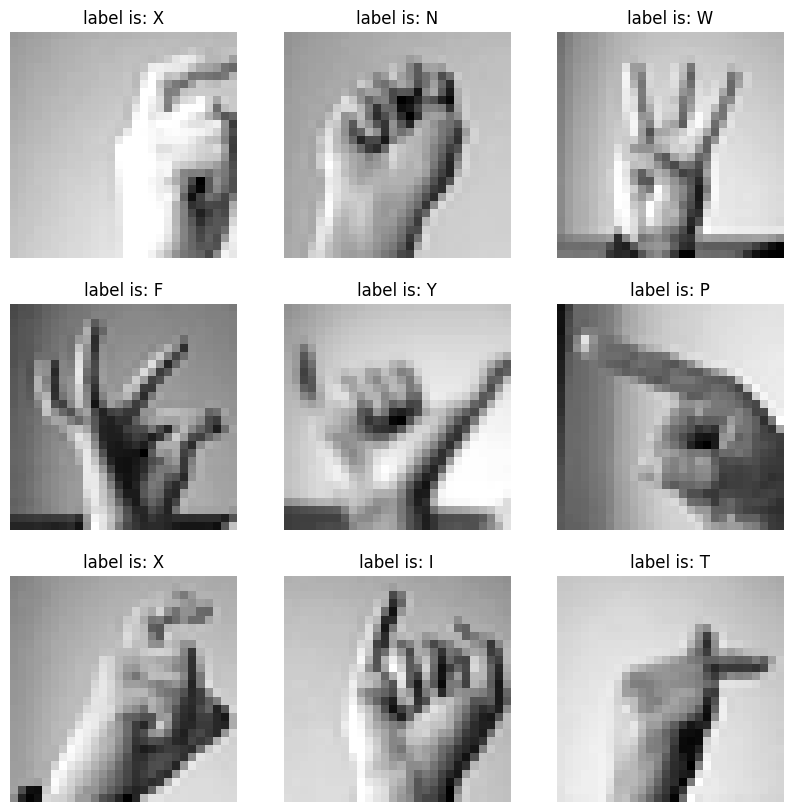

In [177]:
samp = np.random.randint(0, train_x.shape[0], size=(9))

figure = plt.figure(figsize=(10, 10))

col = 3 
row = 3 

for i in range(1, col * row + 1): 
    img = train_x[samp[i - 1]]
    figure.add_subplot(col, row, i)
    plt.title(f"label is: {chr(train_y[samp[i - 1]] + ord('A'))}")
    plt.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="gray")

plt.show()


In [178]:
dataset = CustomDataset(
    train_x, 
    train_y, 
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

BATCH_SIZE=100

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [179]:
class TinyModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 25),
        )
        
        
    def forward(self, x): 
        return self.layers(x)

In [180]:
class TinyModelD(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 25),
        )
        
        
    def forward(self, x): 
        return self.layers(x)

In [216]:
class BigModelD(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Droput(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 25)
#             nn.Dropout(p=0.5),
#             nn.ReLU(),
#             nn.Linear(256, 25)
#             nn.Linear(256, 256),
#             nn.Dropout(p=0.5),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.Dropout(p=0.5),
#             nn.ReLU(),
#             nn.ReLU(),
#             nn.Linear(512, 25)
        )
        
        
    def forward(self, x): 
        return self.layers(x)

In [203]:
def test_model(model, loss_fn, test_x, test_y): 
    t_test_x = torch.tensor(test_x.astype('float32'))
    test_pred = model.forward(t_test_x)
    t_test_y = torch.tensor(test_y)

    cat = np.argmax(test_pred.data, axis=1)


    test_acc = (cat == t_test_y).sum() / t_test_y.shape[0]
    
    return loss_fn(test_pred, t_test_y).data, test_acc 

def train_model(model, optimizer, loss_fn, epochs, Model):
    BATCH_SIZE = 100

    losses, accuracies = [], []
    val_losses, val_accuracies = [], []
    
    best_model_dict = None
    best_val_loss = 1000 * 1000 * 1000 

    for i in (t := trange(epochs)): 

        model.train(True)
        epoch_loss = 0
        epoch_accuracy = 0
        images_count = 0

        for images, labels in dataloader: 
            optimizer.zero_grad()


            x = torch.reshape(images, (-1, 28*28))
            outs = model.forward(x)

            loss = loss_fn(outs, labels)
            loss.backward()

            optimizer.step()

            cat = np.argmax(outs.data, axis=1)

            epoch_loss += loss.data
            epoch_accuracy += (cat == labels).sum().data
            images_count += images.shape[0]

        acc = epoch_accuracy.data / images_count

        losses.append(epoch_loss)
        accuracies.append(acc)
        
        model.train(False)
        val_loss, val_acc = test_model(model, loss_fn, val_x, val_y)
        if val_loss < best_val_loss: 
            best_val_loss = val_loss 
            best_model_dict = model.state_dict()
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        t.set_description("loss %.2f accuracy %.2f" % (val_loss, val_acc))


        
    
    best_model = Model()
    best_model.load_state_dict(best_model_dict)
    
    plt.plot([x for x in range(epochs)], val_losses)
    plt.show()
    
    # test model
    result = test_model(best_model, loss_fn, test_x, test_y)
    print(f"test loss is {result[0]}, test acc is {result[1]}")
    

######### sgd without dropout #########


loss 4.58 accuracy 1.00: 100%|████████████████| 100/100 [01:00<00:00,  1.65it/s]


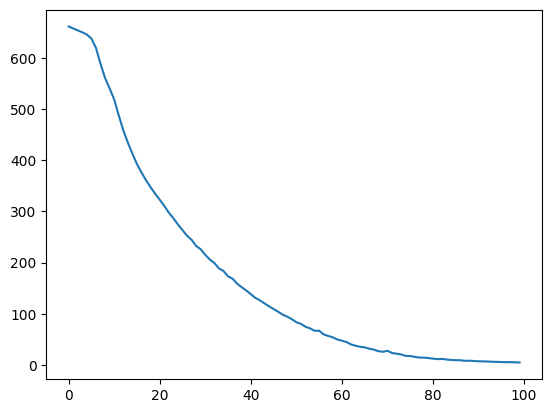

test loss is 452.3031311035156, test acc is 0.6565811634063721


In [198]:
model = TinyModel()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

print("######### sgd without dropout #########")
train_model(model, sgd, loss_fn, 100, TinyModel)

######### adam without dropout #########


loss 42.84 accuracy 0.96: 100%|███████████████████| 7/7 [00:07<00:00,  1.03s/it]


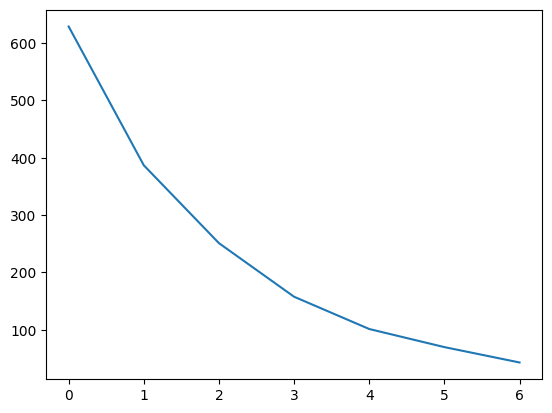

test loss is,  tensor(239.2057)
test acc is,  tensor(0.7323)


In [52]:
model = TinyModel()
adam = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

print("######### adam without dropout #########")
train_model(model, adam, loss_fn, 7)

######### sgd with dropout #########


loss 38.88 accuracy 0.96: 100%|███████████████| 100/100 [01:20<00:00,  1.25it/s]


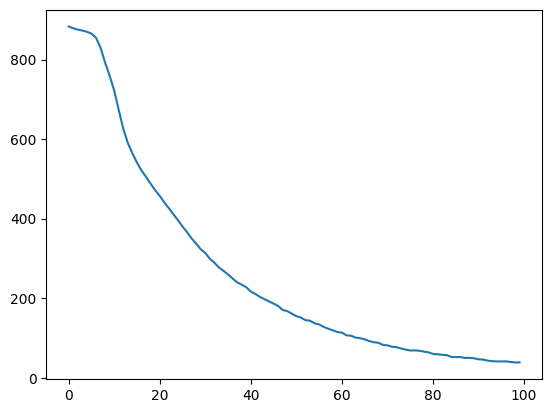

test loss is,  tensor(342.2563)
test acc is,  tensor(0.6393)


In [57]:
model = TinyModelD()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

print("######### sgd with dropout #########")
train_model(model, sgd, loss_fn, 100)

######### adam with dropout #########


loss 0.08 accuracy 1.00: 100%|████████████████| 150/150 [02:10<00:00,  1.15it/s]


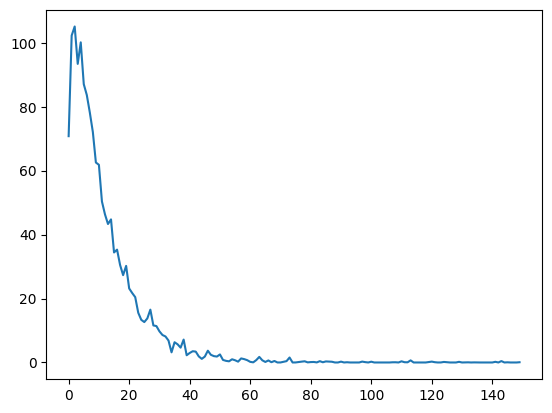

test loss is 329.47222900390625, test acc is 0.7484662532806396


In [208]:
model = TinyModelD()
adam = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

print("######### adam with dropout #########")
train_model(model, adam, loss_fn, 150, TinyModelD)

######### adam with dropout #########


loss 0.00 accuracy 1.00: 100%|████████████████| 400/400 [05:32<00:00,  1.20it/s]


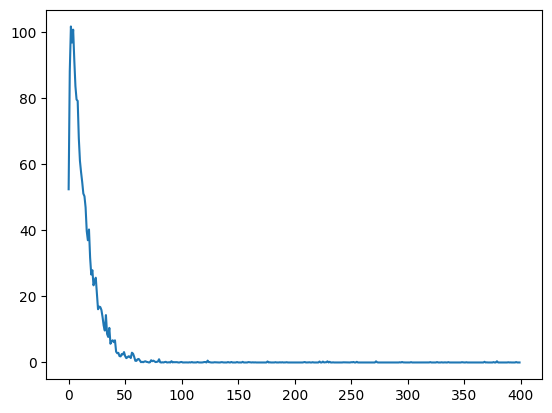

test loss is 371.09979248046875, test acc is 0.7594813108444214


In [217]:
model = TinyModelD()
adam = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

print("######### adam with dropout #########")
train_model(model, adam, loss_fn, 400, TinyModelD)

######### adam with dropout #########


loss 0.09 accuracy 1.00: 100%|████████████████| 500/500 [04:10<00:00,  2.00it/s]


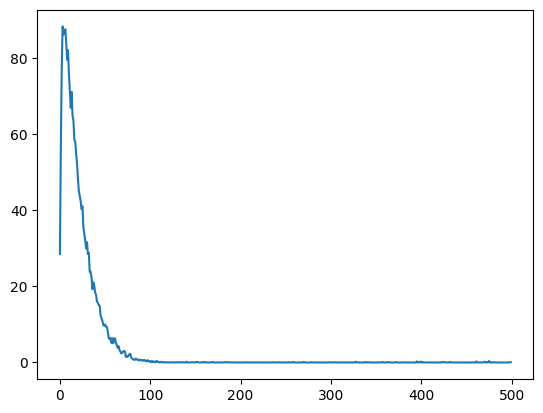

test loss is 605.6072387695312, test acc is 0.6846067905426025


In [209]:
model = BigModelD()
adam = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

print("######### adam with dropout #########")
train_model(model, adam, loss_fn, 500, BigModelD)

``` Difference between Adam and SGD: ```

Adam is much faster but they have almost same result when the learning rate is low. I reached to better results using SGD (75.9%) accuracy with a reasonable time. At the first I didn't have validation data but adding validation helped a lot.  